In [226]:
import numpy as np
import uuid
import pandas as pd
from collections import defaultdict
from tqdm.auto import trange
import matplotlib.pyplot as plt

In [227]:
epochs = 100

In [228]:
df = pd.read_csv('../data/words_translations.csv')
df = df.dropna(subset=['rating'])
df['rating'] = df['rating'].astype(int)
df = df[df['rating'] != 0]
df['translation_created_at'] =  pd.to_datetime(df['translation_created_at'])
df['word_created_at'] = pd.to_datetime(df['word_created_at'])
# create 100 bins
bins = pd.date_range(start=df['translation_created_at'].min(), end=df['translation_created_at'].max(), periods=epochs)
# add a new column to the dataframe with the bin number
df['bin'] = pd.cut(df['translation_created_at'], bins=bins, labels=np.arange(1, epochs, 1))
df.dropna(subset=['bin'], inplace=True)
df['translation_n_words'] = df['translation_body'].str.split().str.len()
df = df[df['translation_n_words'] == 1]
df['translation_body_length'] = df['translation_body'].str.len()

In [229]:
df['translation_id'] =  df['translation_id'].astype(int)


In [230]:
votes = pd.read_csv("../data/votes.csv")
votes['created_at'] = pd.to_datetime(votes['created_at'])
votes['bin'] = pd.cut(votes['created_at'], bins=bins, labels=np.arange(1, epochs, 1))
votes.dropna(subset=['bin'], inplace=True)

In [231]:
# votes should have the same translations as df
votes = votes[votes['translation_id'].isin(df['translation_id'])]

In [232]:
# group by bin and user and count the number of votes
votes_ = votes.groupby(['bin', 'user_id']).size().reset_index(name='votes')
# for each bin, get the list of values in the column 'votes'
votes_ = votes_.query('votes > 0')
votes_ = votes_.groupby('bin')['votes'].apply(list).reset_index(name='votes')
# convert to dictionary
votes_ = votes_.set_index('bin')['votes'].to_dict()

In [233]:
# table with n of unique words and translations per bin
df_unique = df.groupby('bin').agg({'word_id': 'nunique', 'translation_id': 'nunique'}).reset_index()
df_unique.columns = ['bin', 'n_words', 'n_translations']
df_unique

,bin,n_words,n_translations
0,1,8,9
1,2,0,0
2,3,14,18
3,4,3,3
4,5,77,133
...,...,...,...
94,95,280,381
95,96,318,459
96,97,309,404
97,98,220,303


In [234]:
n_words = df_unique['n_words'].to_numpy().round().astype(int)
n_translations = df_unique['n_translations'].to_numpy().astype(int)

In [276]:
class Model:
    
    def __init__(self, n_words, n_translations, lengths, votes, a, b) -> None:
        self.n_words = n_words
        self.n_translations = n_translations

        self.lengths = lengths
        self.votes = votes

        self.n_epochs = self.n_translations.shape[0]

        self.word_pool = defaultdict(list)
        self.translation_pool = defaultdict(list)

        self.a = a
        self.b = b

    def run(self):
        for ep in trange(self.n_epochs):
            n_words_ = self.n_words[ep]
            n_translations_ = self.n_translations[ep]

            # print('Epoch: ', ep)

            [self.word_pool[uuid.uuid1()] for _ in range(n_words_)]
            unique_words = list(self.word_pool.keys())

            # print(len(unique_words))
            
            for t in range(n_translations_):
                word = np.random.choice(unique_words)
                tr = uuid.uuid1()
                self.word_pool[word].append(tr)
                self.translation_pool[tr].append(np.random.choice(self.lengths))
                self.translation_pool[tr].append(0)

            unique_votes = self.votes[ep + 1]

            for v in unique_votes:
                for _ in range(v):
                    word = np.random.choice(unique_words)
                    translations = self.word_pool[word]
                    
                    while not translations:
                        word = np.random.choice(unique_words)
                        translations = self.word_pool[word]
                    # for each translation get length and number of likes
                    lengths = [self.translation_pool[tr][0] for tr in translations]
                    likes = [self.translation_pool[tr][1] for tr in translations]
                    likes_r = (np.array(likes)).argsort().argsort() + 1

                    # calculate the probability of each translation
                    p = np.array((np.array(lengths) ** self.a) + (np.log(likes_r) ** self.b))
                    p = p / p.sum()
                    
                    # randomly choose a translation
                    tr = np.random.choice(translations, p=p)
                    # increase the number of likes for the translation
                    self.translation_pool[tr][1] += 1

In [277]:
a = np.random.randint(1, 40, 5)

# give values in a ranks from 1 to 20 (1 is the largest value)
(1/a).argsort().argsort() + 1

array([1, 5, 4, 3, 2])

In [278]:
a

array([35, 11, 15, 17, 31])

In [279]:
lengths = df['translation_body_length'].to_numpy().astype(int)

a = Model(n_words=n_words, n_translations=n_translations, lengths=lengths, votes=votes_, a=0, b=1)

In [280]:
a.run()

 10%|█         | 10/99 [00:05<00:55,  1.60it/s]

In [ ]:
likes_true = df['rating'].to_numpy().astype(int)
ranked_true = np.argsort(likes_true)[::-1]

In [ ]:
likes_true.sum()

146356

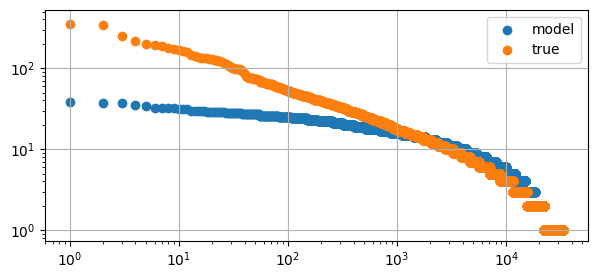

In [ ]:
# get the number of likes for each translation
likes = [a.translation_pool[tr][1] for tr in a.translation_pool.keys()]
# ramk the translations by the number of likes
ranked = np.argsort(likes)[::-1]
# plot rank and likes as y and x
plt.figure(figsize=(7, 3))
plt.scatter(np.arange(len(ranked)), np.array(likes)[ranked], label = 'model')
plt.scatter(np.arange(len(ranked_true)), np.array(likes_true)[ranked_true], label = 'true')
plt.legend()
# log log scales
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

In [ ]:
sum(likes)

145781

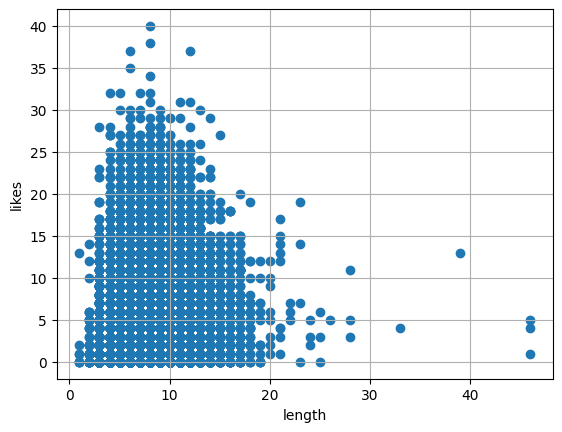

In [ ]:
# plot length likes correlation from the translation pool
lengths = [a.translation_pool[tr][0] for tr in a.translation_pool.keys()]
likes = [a.translation_pool[tr][1] for tr in a.translation_pool.keys()]

plt.scatter(lengths, likes)
plt.xlabel('length')
plt.ylabel('likes')
plt.grid()
plt.show()